你点击了屏幕画面的点：(x=56, y=82)
存储的屏幕点击坐标： [[56 82]]


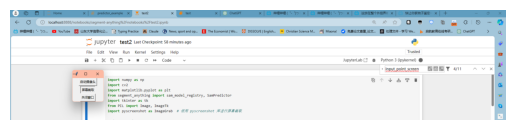

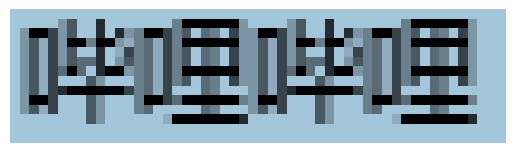

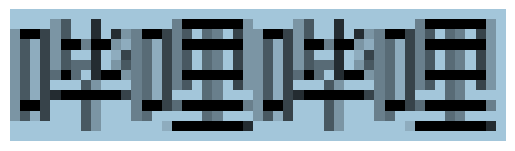

你点击了屏幕画面的点：(x=1777, y=888)
存储的屏幕点击坐标： [[1777  888]]


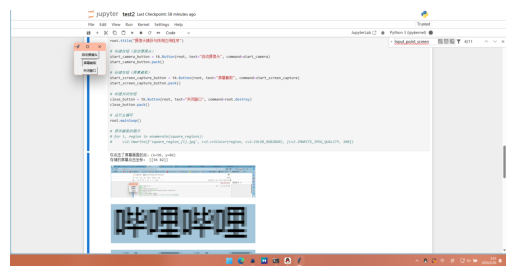

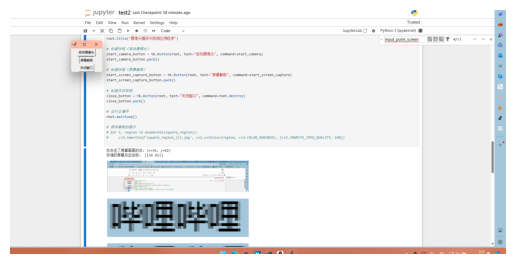

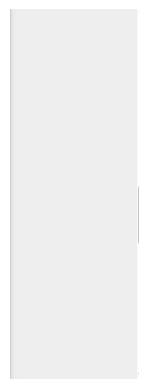

你点击了屏幕画面的点：(x=1142, y=496)
存储的屏幕点击坐标： [[1142  496]]


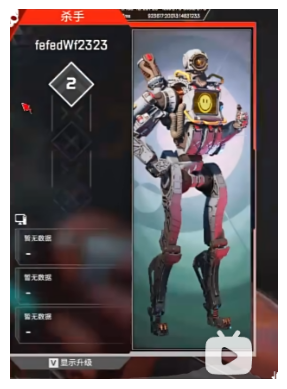

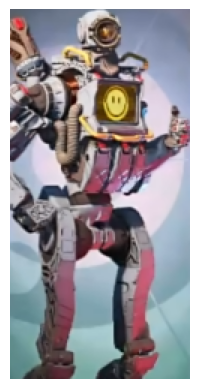

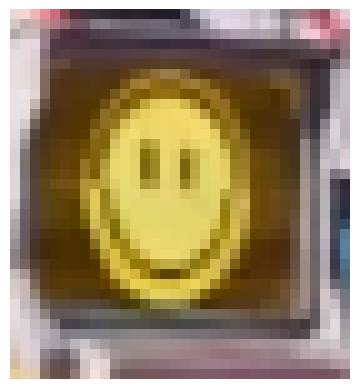

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
import tkinter as tk
from PIL import Image, ImageTk
import pyscreenshot as ImageGrab  # 使用 pyscreenshot 库进行屏幕截取

# 初始化全局变量
square_regions = []
input_point_camera = None
input_point_screen = None
# 定义鼠标点击事件的回调函数（用于摄像头捕获）
def on_mouse_camera(event, x, y, flags, param):
    global input_point_camera
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f'你点击了摄像头画面的点：(x={x}, y={y})')
        # 存储点击的坐标
        input_point_camera = np.array([[x, y]])
        # 清空之前的方块区域
        square_regions.clear()

# 定义鼠标点击事件的回调函数（用于屏幕截取）
def on_mouse_screen(event, x, y, flags, param):
    global input_point_screen
    input_point_screen = None
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f'你点击了屏幕画面的点：(x={x}, y={y})')
        # 存储点击的坐标
        input_point_screen = np.array([[x, y]])
        # 清空之前的方块区域
        square_regions.clear()

def start_camera():
    global square_regions

    square_regions = []

    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print('无法打开摄像头')
    else:
        print('摄像头已打开')

        while True:
            ret, frame = cap.read()
            if not ret:
                print('未能从摄像头读取画面')
                break

            cv2.imshow('Camera', frame)
            cv2.setMouseCallback('Camera', on_mouse_camera)

            key = cv2.waitKey(1) & 0xFF
            if input_point_camera is not None:
                break

        if input_point_camera is not None:
            print('存储的摄像头点击坐标：', input_point_camera)
            predict_image_region(frame, input_point_camera)

        cap.release()
        cv2.destroyAllWindows()

def start_screen_capture():
    global square_regions

    square_regions = []

    screenshot = ImageGrab.grab()
    screenshot = cv2.cvtColor(np.array(screenshot), cv2.COLOR_RGB2BGR)

    while True:
        cv2.imshow('Screen', screenshot)
        cv2.setMouseCallback('Screen', on_mouse_screen)

        key = cv2.waitKey(1) & 0xFF
        if input_point_screen is not None:
            break

    if input_point_screen is not None:
        print('存储的屏幕点击坐标：', input_point_screen)
        predict_image_region(screenshot, input_point_screen)
    # input_point_screen = None
    cv2.destroyAllWindows()

def predict_image_region(image, input_point):
    global square_regions

    sam_checkpoint = "sam_vit_b_01ec64.pth"
    model_type = "vit_b"
    device = "cuda"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    predictor = SamPredictor(sam)
    predictor.set_image(image)

    input_label = np.array([1])

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    for i, (mask, score) in enumerate(zip(masks, scores)):
        non_zero_indices = np.nonzero(mask)
        # 获取最上、最下、最左、最右的坐标
        topmost = np.min(non_zero_indices[0])
        bottommost = np.max(non_zero_indices[0])
        leftmost = np.min(non_zero_indices[1])
        rightmost = np.max(non_zero_indices[1])
        top, bottom, left, right = topmost, bottommost, leftmost, rightmost
        square_region = image[top:bottom + 1, left:right + 1]
        square_region_rgb = cv2.cvtColor(square_region, cv2.COLOR_BGR2RGB)
        square_regions.append(square_region_rgb)
        # 显示截取的方块区域
        plt.imshow(square_region_rgb)
        plt.axis('off')
        plt.show()

# 创建主窗口
root = tk.Tk()
root.title("摄像头捕获与预测应用程序")

# 创建按钮（启动摄像头）
start_camera_button = tk.Button(root, text="启动摄像头", command=start_camera)
start_camera_button.pack()

# 创建按钮（屏幕截取）
start_screen_capture_button = tk.Button(root, text="屏幕截取", command=start_screen_capture)
start_screen_capture_button.pack()

# 创建关闭按钮
close_button = tk.Button(root, text="关闭窗口", command=root.destroy)
close_button.pack()

# 运行主循环
root.mainloop()

# 保存截取的图片
# for i, region in enumerate(square_regions):
#     cv2.imwrite(f'square_region_{i}.jpg', cv2.cvtColor(region, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, 100])


In [4]:
cv2.imwrite('square_region_0.jpg', cv2.cvtColor(square_regions[1], cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, 100])
local_file_path1 = 'file://F:/personal/2024_hackathon_project/segment-anything/notebooks/square_region_0.jpg'

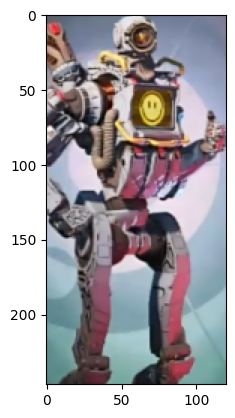

In [5]:
plt.imshow(square_regions[1])

In [8]:
from dashscope import MultiModalConversation
from http import HTTPStatus
import dashscope
dashscope.api_key = 'sk-c8e61bbacecf4348b17f48812d4b5269'


def call_with_local_file():
    """Sample of use local file.
       linux&mac file schema: file:///home/images/test.png
       windows file schema: file://D:/images/abc.png
    """
    messages = [{
        'role': 'system',
        'content': [{
            'text': 'You are a one of the best English teacher in the world.I am a English person.'
        }]
    }, {
        'role':
        'user',
        'content': [
            {
                'image': local_file_path1
            },
            {
                'text': 'According to the objects shown in the picture, give the corresponding words, phonetic symbols and relevant example sentences,you dont need to send the picture back. If the object is complex, answer with the closest name.Please return in the following json format {"english_word","phonetic_symbols","relevant_example_sentences"}'
            },
        ]
    }]
    response = MultiModalConversation.call(model='qwen-vl-plus', messages=messages)
    print(response)
    return response


response_origin = call_with_local_file()

{"status_code": 200, "request_id": "0da0018b-97ef-9580-8ecc-f81000683354", "code": "", "message": "", "output": {"text": null, "finish_reason": null, "choices": [{"finish_reason": "stop", "message": {"role": "assistant", "content": [{"text": "{\"robot\",\"/ˈrəʊbət/\" , \"The robot was cleaning the house.\"}"}]}}]}, "usage": {"input_tokens": 136, "output_tokens": 23, "image_tokens": 36}}


In [9]:
response = response_origin
response['output']['choices'][0].message['content'][0]['text']

'{"robot","/ˈrəʊbət/" , "The robot was cleaning the house."}'

In [12]:
input_point_screen= None
input_point_screen